# This notebook uses all the script to train a CAE for DNase

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The base directory is one level up
base = '..'
settings_filepath = '../settings-grch38-dnase-12kb-testing.json'
cnn_search_filepath = '../cnn-search.json'

### Load settings

In [2]:
with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(cnn_search_filepath, "r") as f:
    search = json.load(f)

### 1. Find DNase datasets on ENCODE

In [3]:
from find import find

datasets_filepath = find(settings, base=base, clear=False, verbose=True)

File already exists. Use `--clear` to overwrite it.


In [4]:
# Comment out or remove the following line. It's only used for testing
datasets_filepath = '../datasets-grch38-dnase-testing.json'
with open(datasets_filepath, "r") as f:
    datasets = json.load(f)
    dataset_ids = list(datasets.keys())

### 2. Download the datasets

In [5]:
from download import download

download(datasets, settings, base=base, clear=False, verbose=True)

Using TensorFlow backend.


The data will be downloaded to `../data`.

### 3. Create jobs for preparing all the datasets

In [28]:
from prepare import prepare_jobs

prepare_jobs(
    'DNase',
    os.path.relpath(datasets_filepath, base),
    os.path.relpath(settings_filepath, base),
    base=base,
    clear=True,
    verbose=False,
)


Created slurm files for preparing 2 datasets


The slurm files for the individual preparation will be located in `prepare`.

### 3.5 Test data preparation

In [29]:
from prepare import prepare

prepare(
    'DNase',
    datasets,
    settings,
    # single_dataset='ENCSR320PGJ',
    base=base,
    clear=False,
    verbose=False,
)

Already prepared ENCSR320PGJ. Skipping


Already prepared ENCSR354FBA. Skipping



### 4. Create jobs for training various CAE models

In [ ]:
from jobs import jobs

jobs(
    search,
    settings, 
    epochs=25,
    batch_size=32,
    peak_weight=1,
    base=base,
    clear=False,
    verbose=False
)

### 5. Test CAEs training

In [8]:
model_name = 'cf-128--ck-11--du-512-128--do-0-0-0--e-10--rl-0--o-adam--lr-0.01--lrd-0.0--l-bce--m-'

In [75]:
from train import train

# Load the CAE definition, training settings, datasets, and define training parameters
with open('../slurm/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

epochs = 2
batch_size = 32
peak_weight = 1 # Is not used right now

# Start the training
train(
    definition,
    settings,
    dataset_ids,
    epochs=epochs,
    batch_size=batch_size,
    peak_weight=peak_weight,
    base=base,
    clear=False
)

#### Visualize training and validation loss

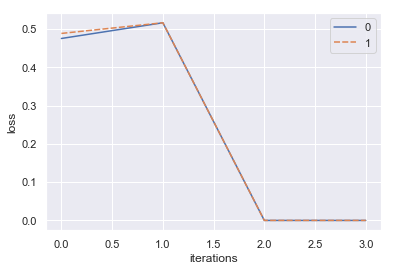

In [13]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

with h5py.File(
    os.path.join(base, 'models', '{}---training.h5'.format(model_name)), 'r'
) as f:
    data = np.zeros((f['loss'].shape[0], 2))
    data[:,0] = f['loss'][:]
    data[:,1] = f['val_loss'][:]

    ax = sns.lineplot(data=pd.DataFrame(data))
    ax.set(xlabel='iterations', ylabel='loss')

### 6. Evaluate CAEs

In [25]:
from evaluate import evaluate

evaluate(
    model_name,
    datasets,
    base=base,
    clear=True
)